# Loading the trained model and Concatenation of the Street Numbers

## 1. Libraries

In [32]:
import time
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

import numpy as np
from PIL import Image, ImageFont, ImageDraw 
import matplotlib.pyplot as plt
import warnings
import os
import cv2
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline  

## 2. Load the trained Model

In [2]:
PATH_TO_SAVED_MODEL = "../RealTimeObjectDetection/Tensorflow/workspace/models/efficientdetd0/exp_1/freeze_model/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...WARNING:tensorflow:Importing a function (__inference_bifpn_layer_call_and_return_conditional_losses_67107) with ops with custom gradients. Will likely fail if a gradient is requested.


Done! Took 27.58759379386902 seconds


## 3. Load the Labelmap for the detections

In [3]:
PATH_TO_LABELS = "../RealTimeObjectDetection/Tensorflow/workspace/annotations/label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,use_display_name=True)

## 4. Detectection and Concatenation of Street Numbers

In [39]:
#function that concatenates the numbers from an image

import numpy as np

def concatenate(bbs_int,classes):
    #print(bbs_int)
    order=np.copy(classes)
    x=np.zeros(order.shape) #left
    y=np.zeros(order.shape) #down
    c=0
   
    right = np.zeros(order.shape) #right
    top = np.zeros(order.shape) #top
    size = [] #helper for size
   
    #print(order)
    for i in bbs_int:
        x[c]=i[1] # left
        y[c]=i[0] # down
        top[c] =  i[2] # top
        right[c] = i[3] # right
       
        c=c+1
    axy=[]
    cz=0
    cx=0
   
    for z in x:
        for h in x:
            if cx+cz<len(x)-1:
                axy.append(abs(z-x[cz+cx+1]))
            cx=cx+1
        cz=cz+1
        cx=0
       
    #calculate size
    #print(len(order))
    outofrange = []
    avgs = 0
    avgarea = 0
    dearea = 0
   
    if order != []:
        for s in range(len(order)):
            size.append((top[s]-y[s])*(right[s]-x[s]))
        #calculate mean of size
        for m in size:
            avgs += m
        avgarea = avgs / len(size)
        #print(avgarea)
        #caclular standart derivation
        helper = 0
        for sd in range(len(size)):
            helper += pow((size[sd] - avgarea),2)
        dearea = pow((helper/len(size)),.5)  
        #print(size)
        #print(avgarea)
        #print(dearea)
    #eliminate elements out of range
        for e in range(len(size)):
            if((size[e] > avgarea+(2*dearea)) or (size[e] < avgarea-(2*dearea))):
                outofrange.append(e)
        if outofrange != [] :
            for el in outofrange:
                order = np.delete(order,el)
                x = np.delete(x,el)
                y = np.delete(y,el)
                top = np.delete(top,el)
                right = np.delete(right,el)
   
    avg=1000000
    if axy!=[]:
        sum=0
        for f in axy:
            sum=f+sum
        avg=sum/len(axy)
    #print(axy)
    #print(avg)
   
    #verticalnumber
    if avg<=2:
        order=order[y.argsort()]
       
        if len(order) > 1:
            y = y[y.argsort()]
            top = top[top.argsort()]
            distance = 0
            hed = []
            for large in range(len(order)-1):
                hed.append(abs(y[large] - top[large+1]))
                distance += abs(y[large] - top[large+1])
            avgdistance = distance/ (len(order)-1)
            helperd = 0
            for dis in hed:
                helperd += pow((dis - avgdistance),2)
            desdis = pow((helperd/len(hed)),.5)
            print(avgdistance)
            print(desdis)
            print(hed)
            outdistance = []
            for od in range(len(order)-1):
                if((hed[od] > avgdistance+(1.5*desdis)) or (hed[od] < avgdistance-(1.5*desdis))):
                    outdistance.append(od)
            if outdistance != [] :
                for eli in outdistance:
                    if eli == 0:
                        order = np.delete(order,eli)
                    elif len(order) > eli+1:
                        order = np.delete(order,eli+1)
                       
        order=order.astype(str)
        order=''.join(order)
 
    else:    
        order=order[x.argsort()]
       
        if len(order) > 1:
            x = x[x.argsort()]
            right = right[right.argsort()]
            distance = 0
            hed = []
            for ancho in range(len(order)-1):
                hed.append(abs(right[ancho] - x[ancho+1]))
                distance += abs(right[ancho] - x[ancho+1])
            avgdistance = distance/ (len(order)-1)
            helperd = 0
            for dis in hed:
                helperd += pow((dis - avgdistance),2)
            desdis = pow((helperd/len(hed)),.5)
            print(avgdistance)
            print(desdis)
            print(hed)
            outdistance = []
            for od in range(len(order)-1):
                if((hed[od] > avgdistance+(1.5*desdis)) or (hed[od] < avgdistance-(1.5*desdis))):
                    outdistance.append(od)
            if outdistance != [] :
                for eli in outdistance:
                    if eli == 0:
                        order = np.delete(order,eli)
                    elif len(order) > eli+1:
                        order = np.delete(order,eli+1)
           
       
        order=order.astype(str)
        order=''.join(order)
        #order=int(order)
    return order

471.png
Running inference for 471.png... 0.7434943988919258
0.0
[0.7434943988919258]
481.png
Running inference for 481.png... 0.38940882682800293
0.053271302145277435
[0.32750949263572693, 0.3209298253059387, 0.4336811602115631, 0.43320196866989136, 0.43172168731689453]
482.png
Running inference for 482.png... 0.6858816519379616
0.0028457418084144592
[0.6830359101295471, 0.688727393746376]
483.png
Running inference for 483.png... 0.8018679730594158
0.0
[0.8018679730594158]
499.png
Running inference for 499.png... 501.png
Running inference for 501.png... 0.43846043944358826
0.0
[0.43846043944358826]
504.png
Running inference for 504.png... 0.723200112581253
0.0
[0.723200112581253]
507.png
Running inference for 507.png... 509.png
Running inference for 509.png... 0.6216395869851112
0.00259525328874588
[0.6190443336963654, 0.6242348402738571]
520.png
Running inference for 520.png... 0.667886283248663
0.026677381247282028
[0.6412089020013809, 0.694563664495945]
522.png
Running inference for

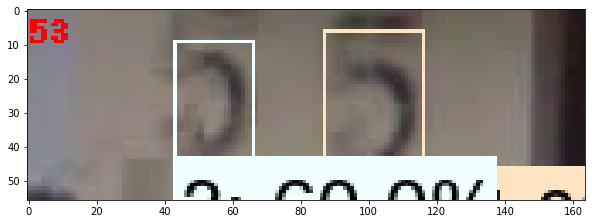

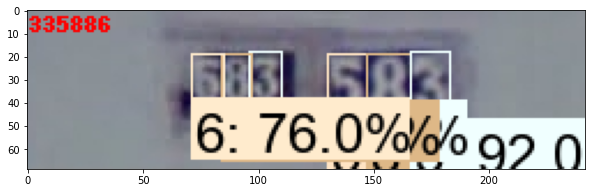

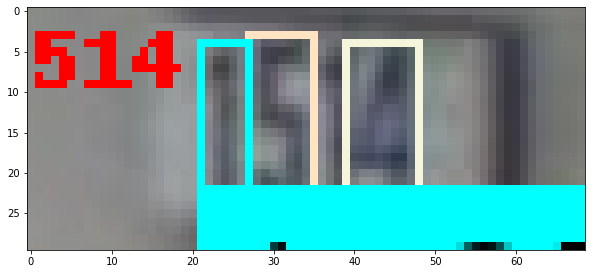

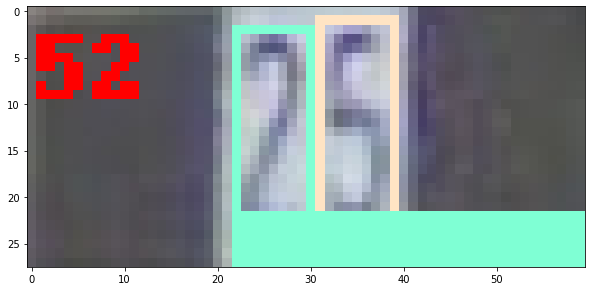

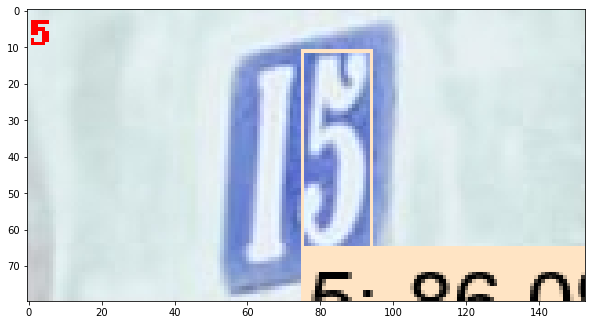

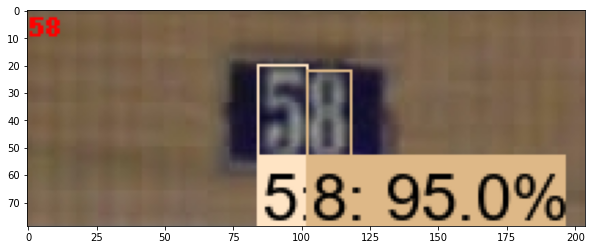

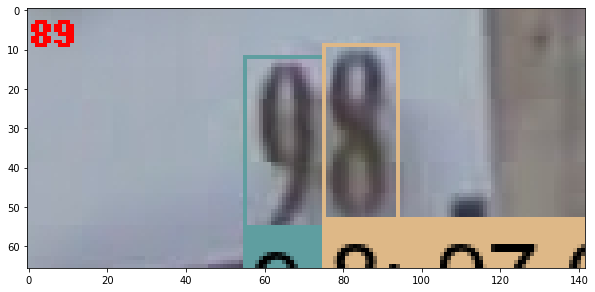

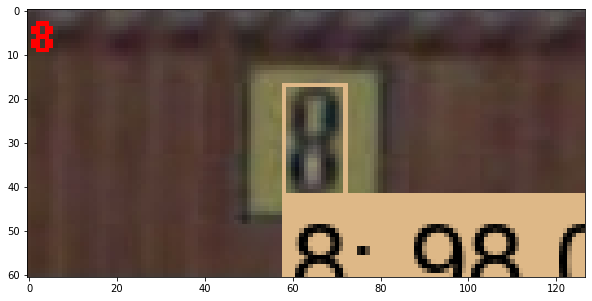

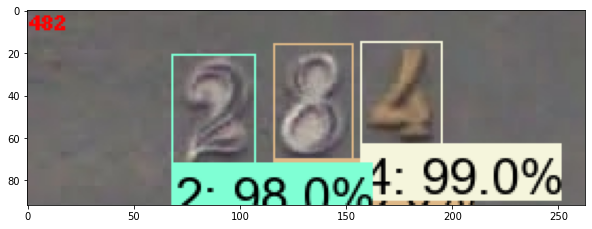

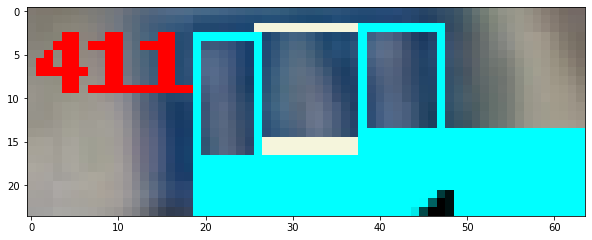

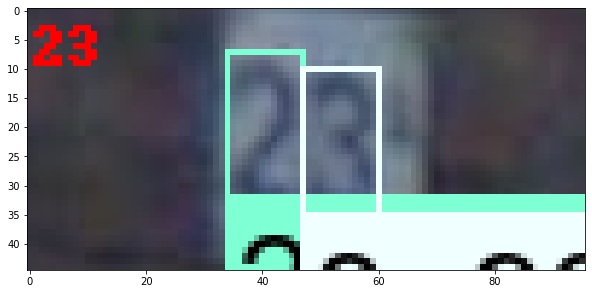

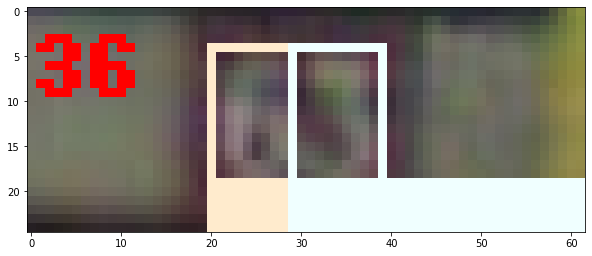

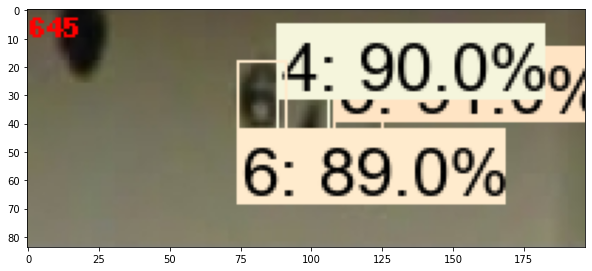

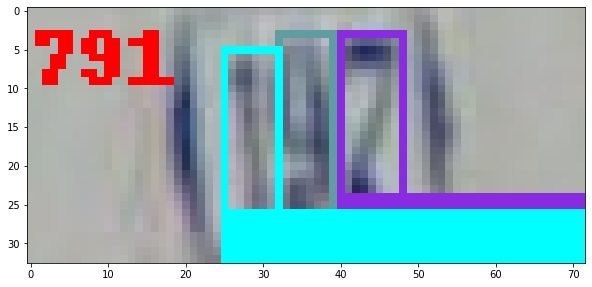

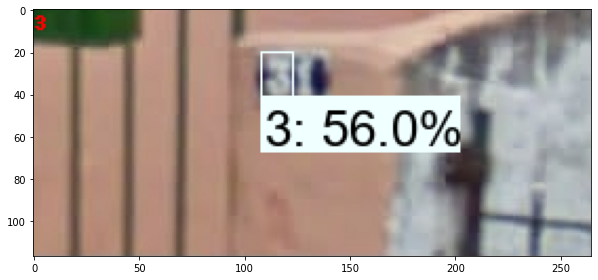

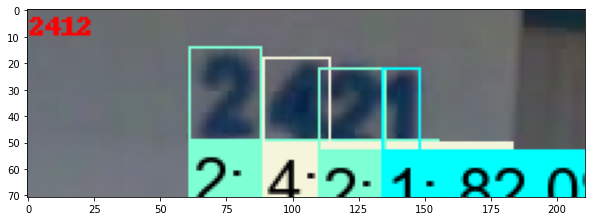

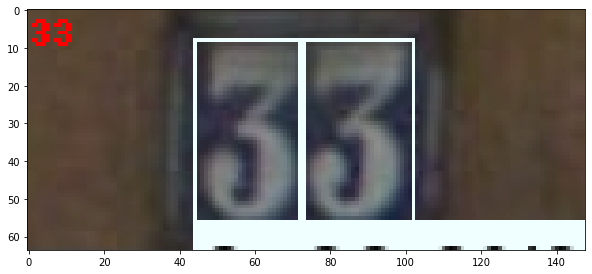

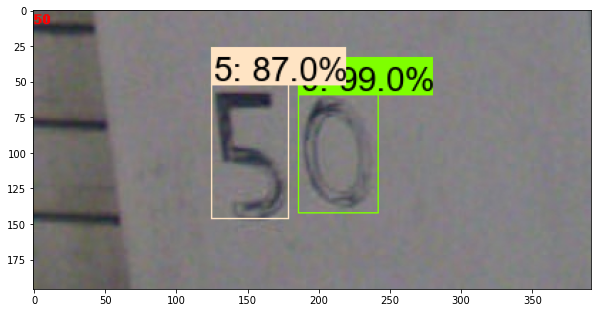

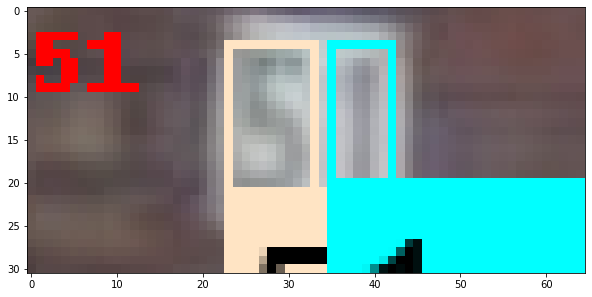

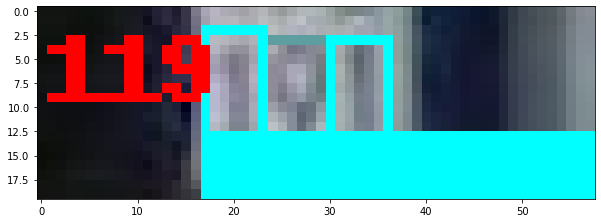

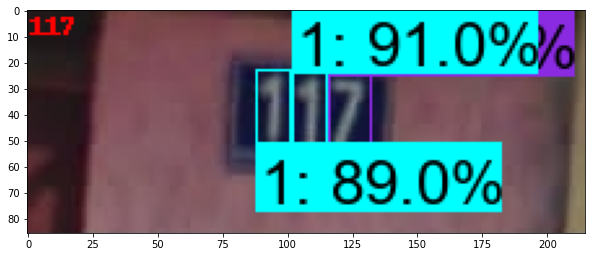

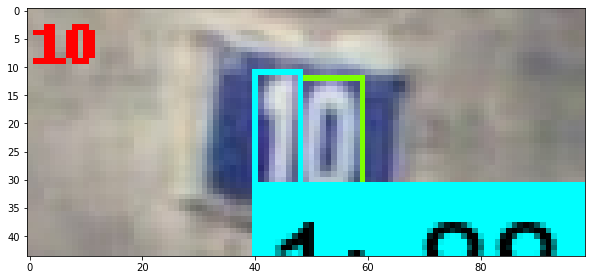

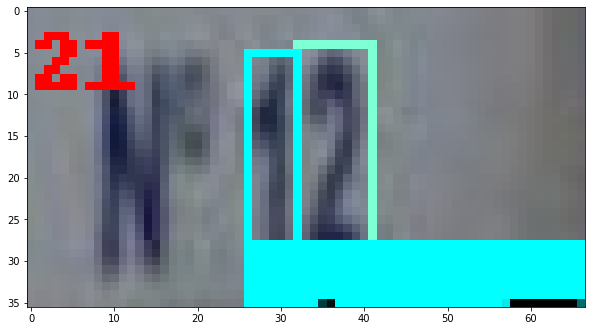

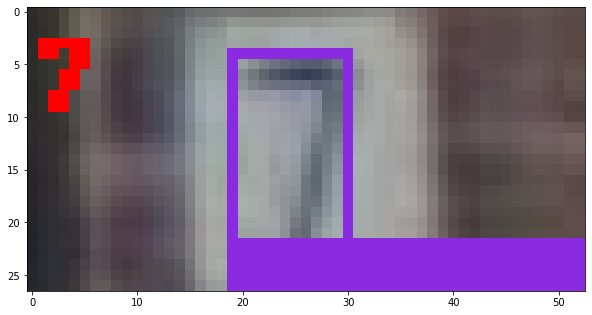

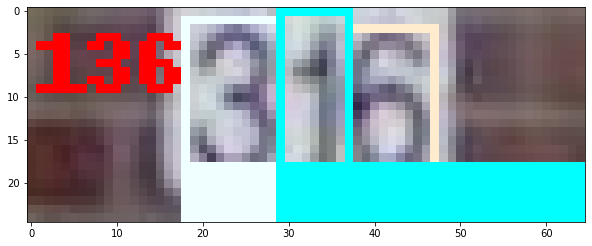

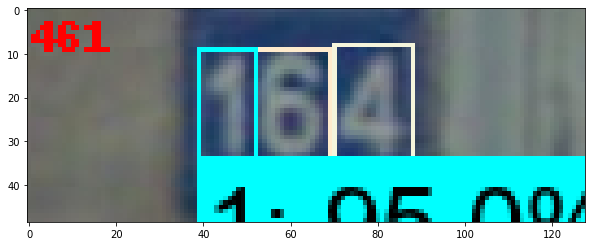

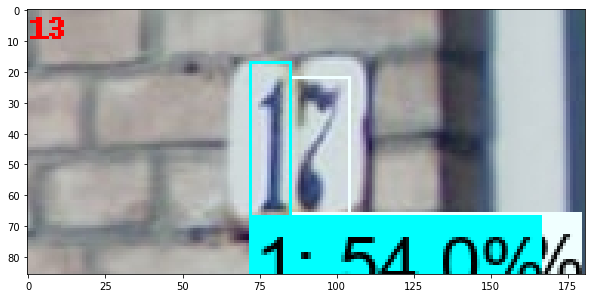

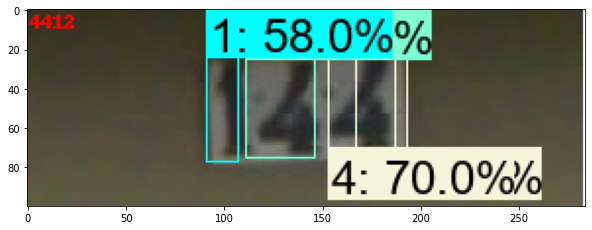

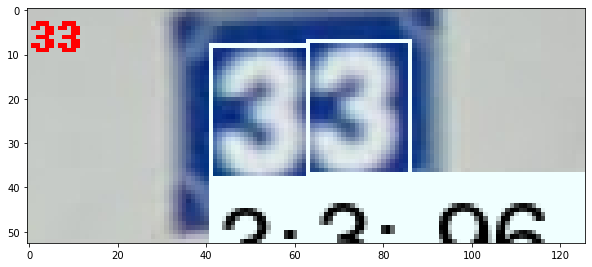

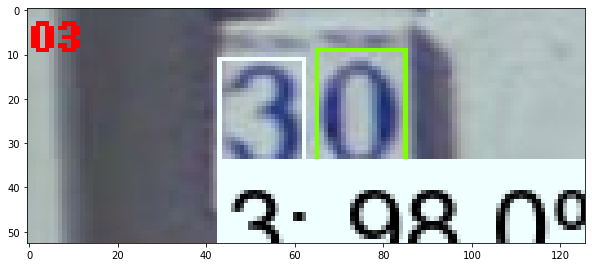

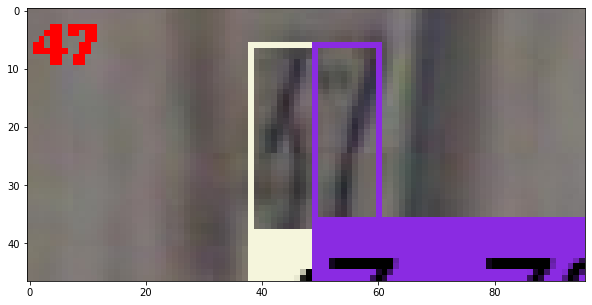

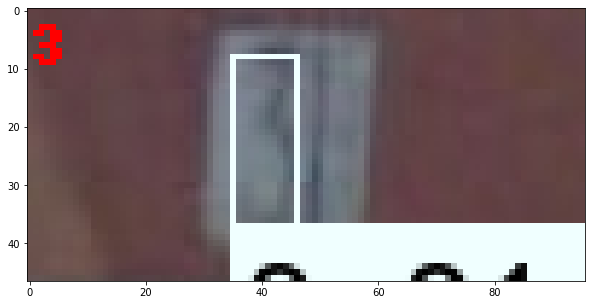

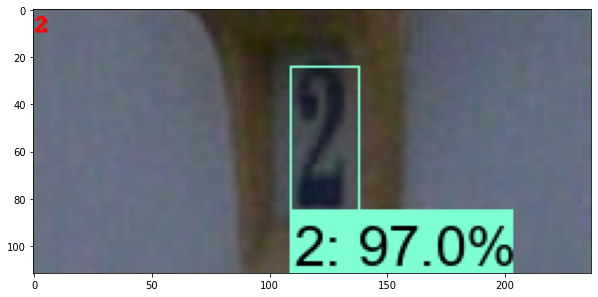

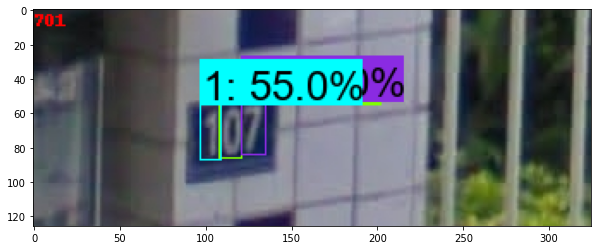

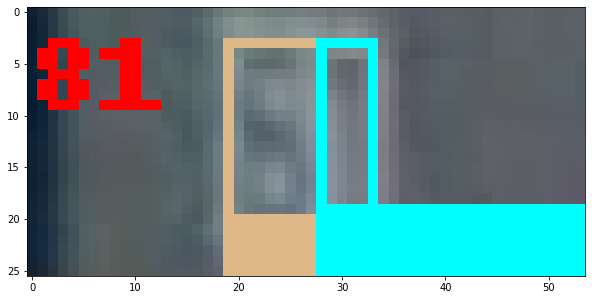

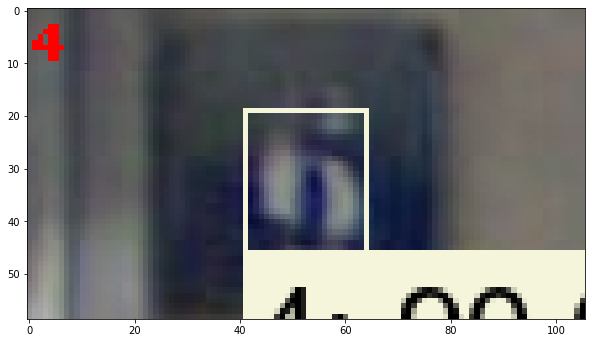

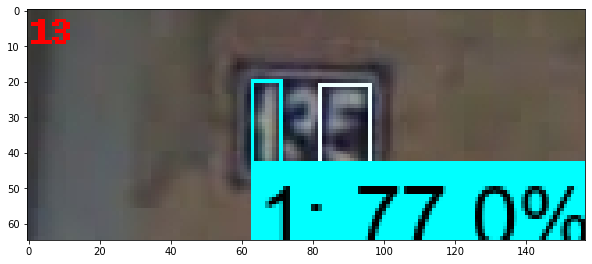

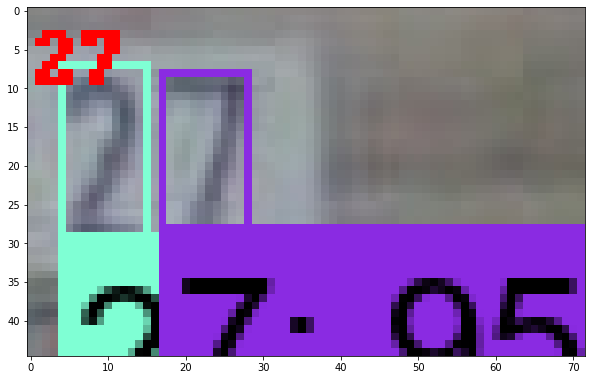

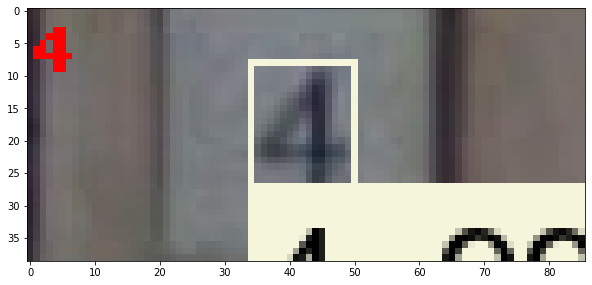

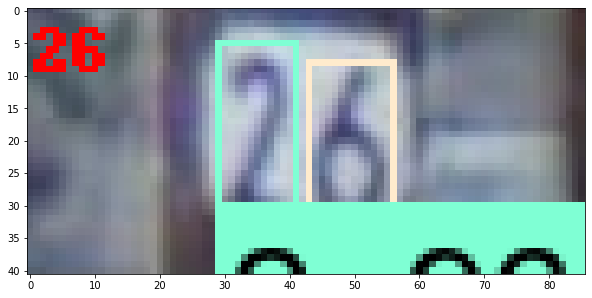

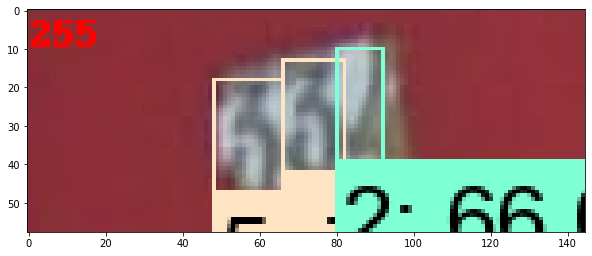

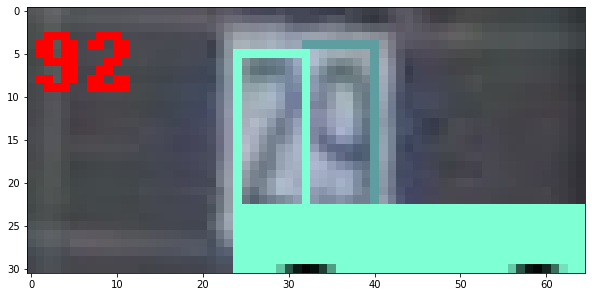

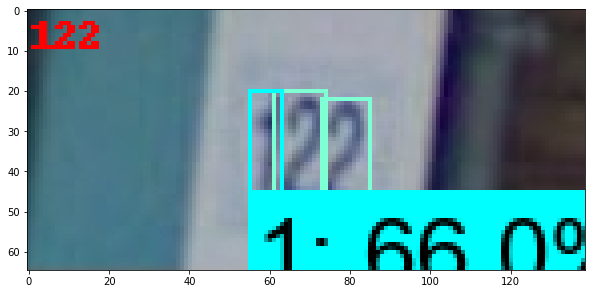

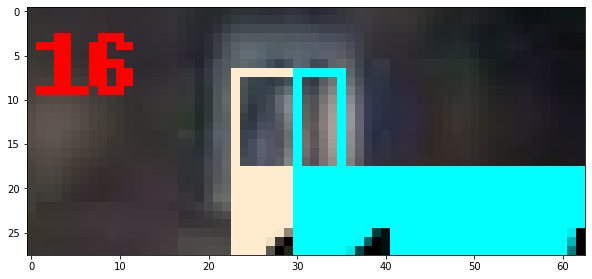

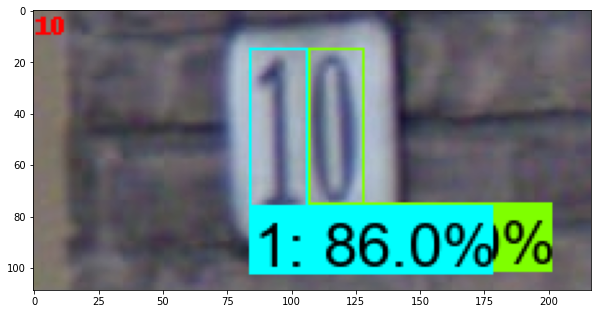

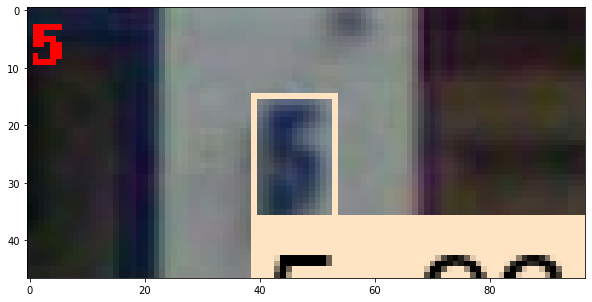

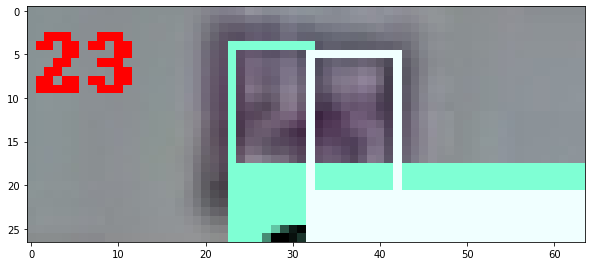

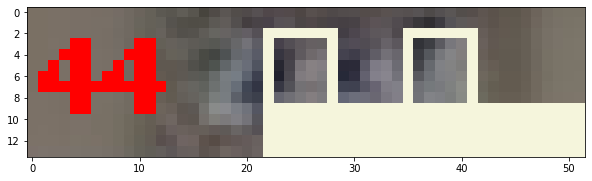

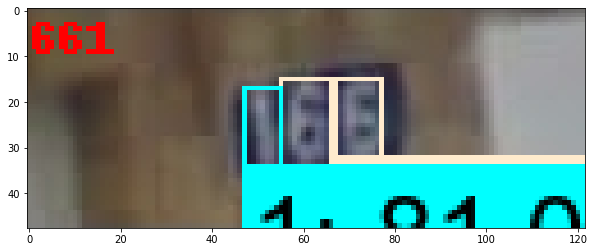

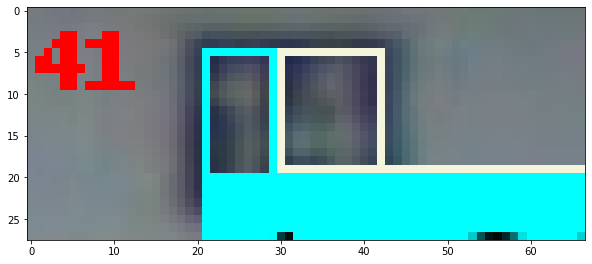

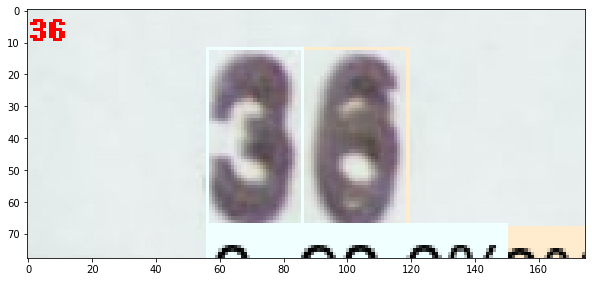

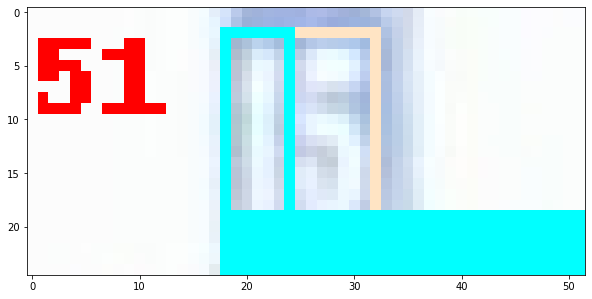

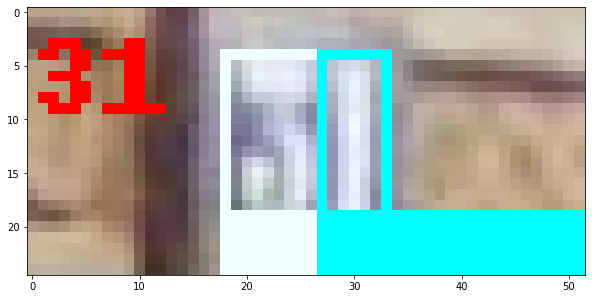

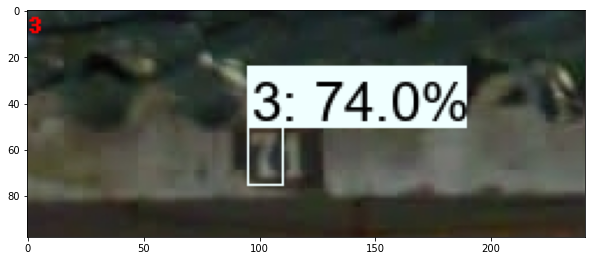

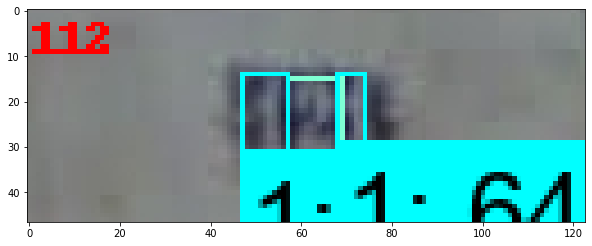

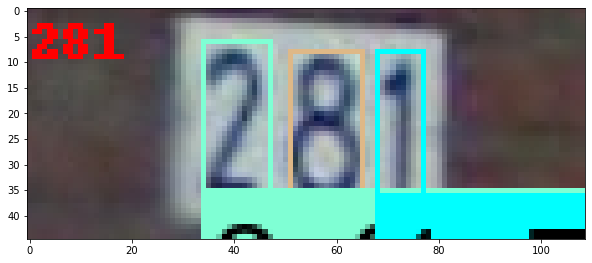

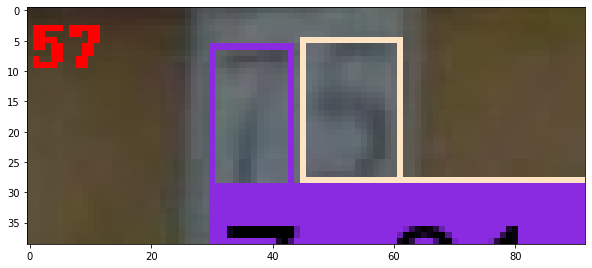

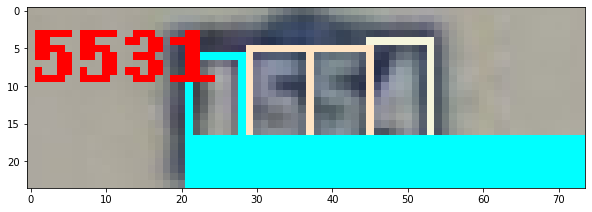

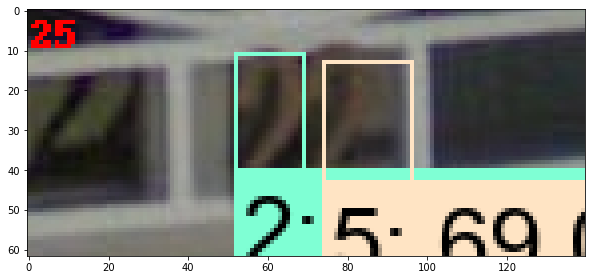

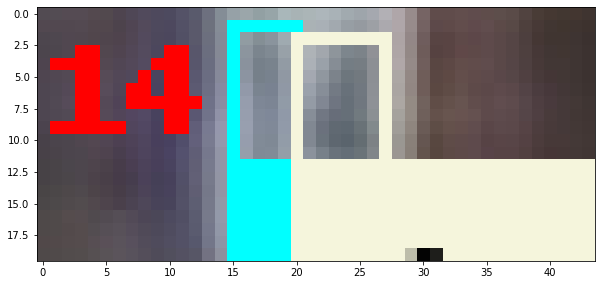

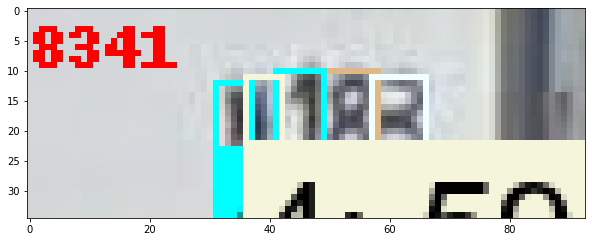

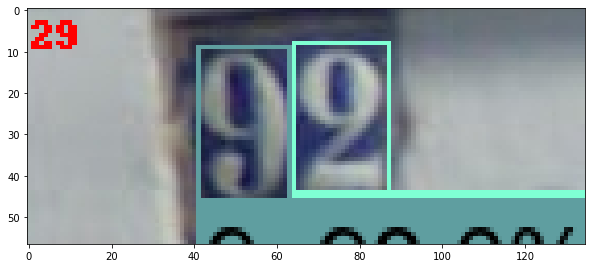

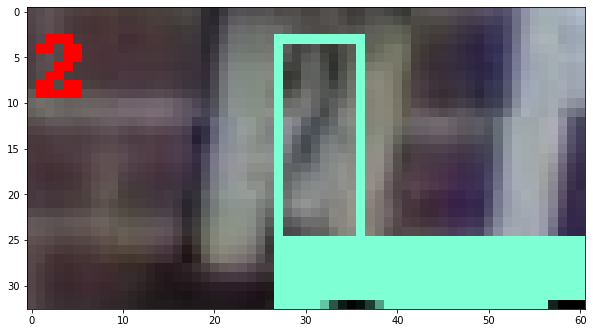

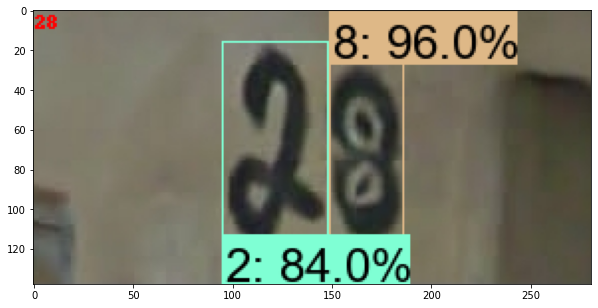

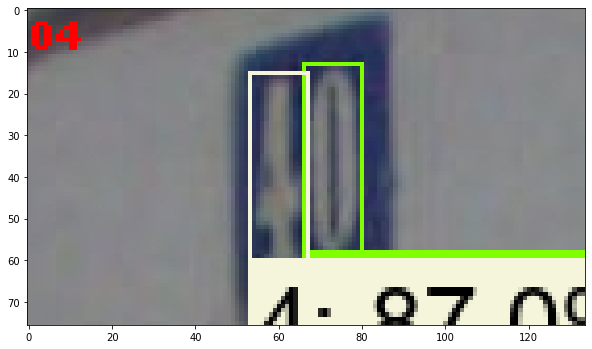

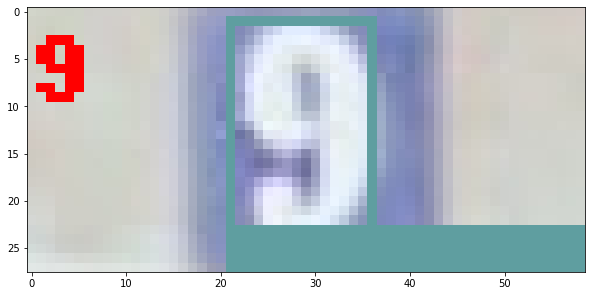

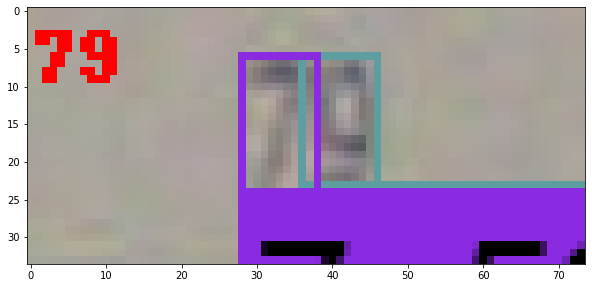

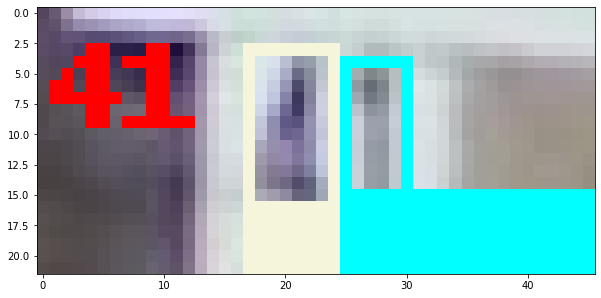

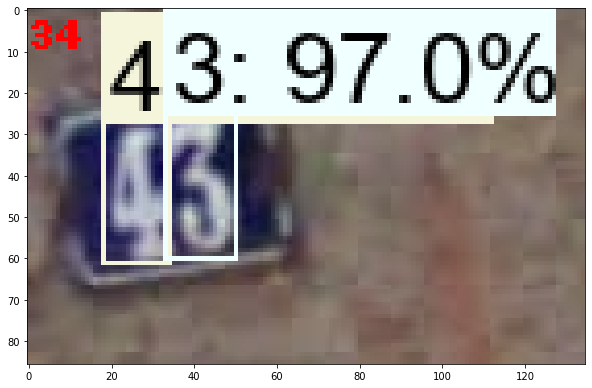

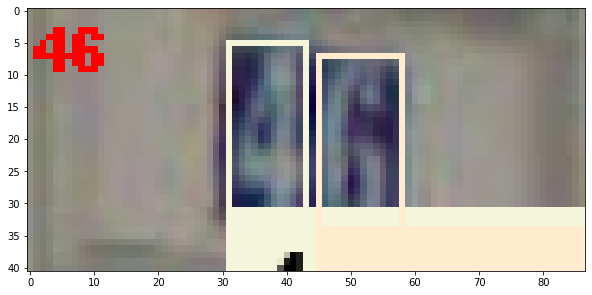

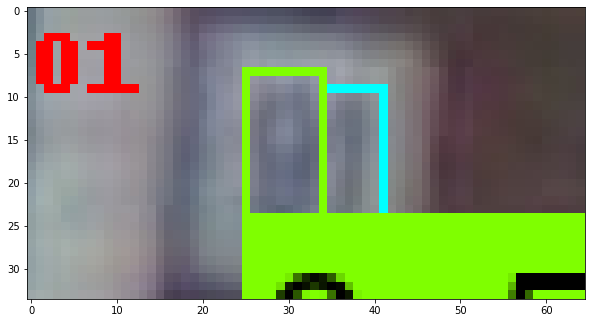

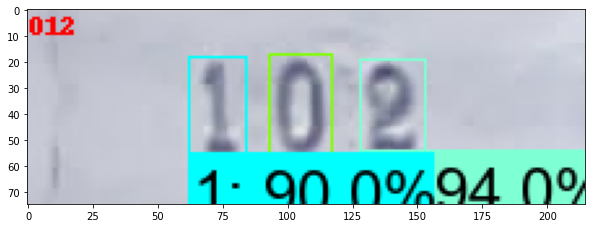

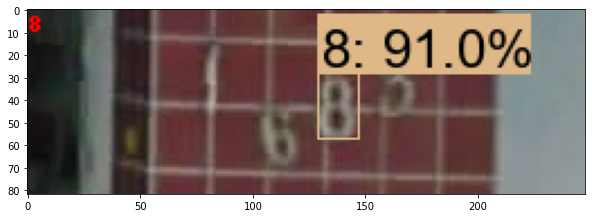

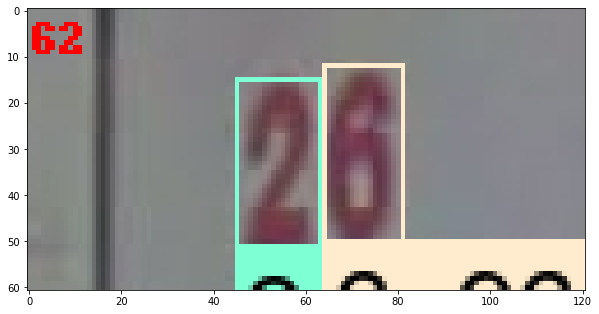

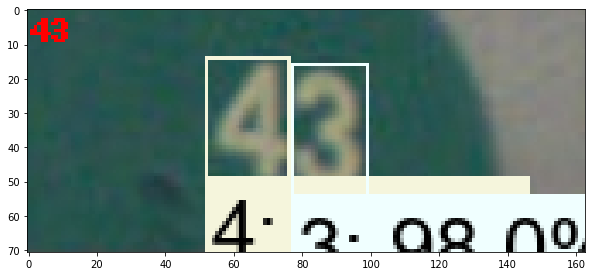

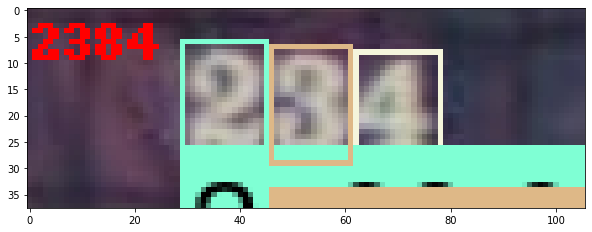

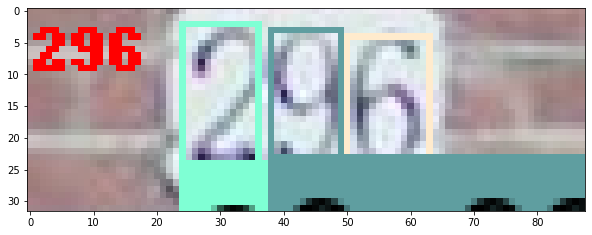

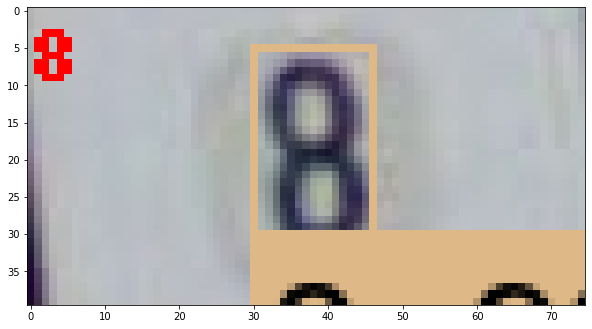

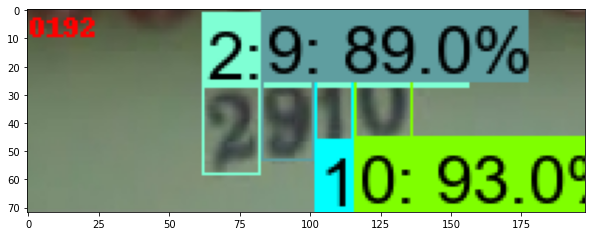

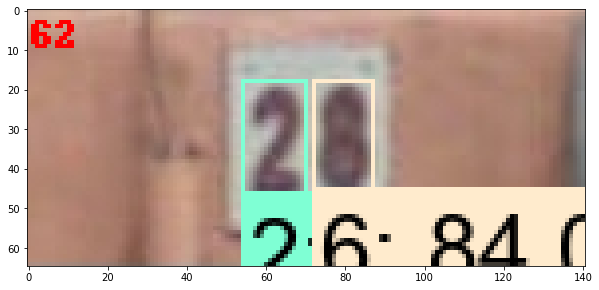

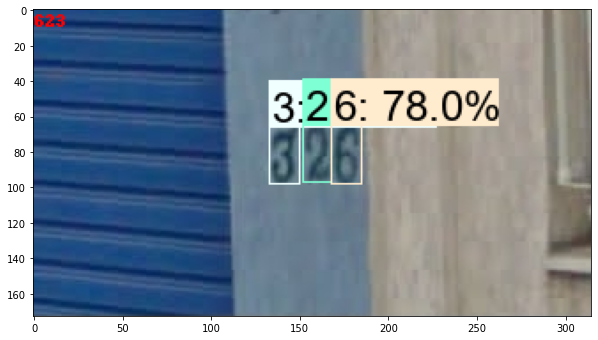

In [40]:
IMAGE_PATHS = os.listdir('./Imagenes/')
dict_classes =	{ 1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9}

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open('./Imagenes/'+path))


for image_path in IMAGE_PATHS:
    print(image_path)

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    #image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()
    
    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          line_thickness=1,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.50,
          agnostic_mode=False)
    
    detections['detection_classes'] = [*map(dict_classes.get, detections['detection_classes'])]
    scores = detections['detection_scores'][detections['detection_scores'] > 0.50]
    bb = detections['detection_boxes'][0:scores.size]
    classes = detections['detection_classes'][0:scores.size]
    
    street_number = concatenate(bb,classes)
    img = Image.fromarray(np.uint8(image_np_with_detections)).convert('RGB')
    d1 = ImageDraw.Draw(img)
    d1.text((1, 1), street_number, fill=(255, 0, 0))
    plt.figure(figsize=(10,20))
    plt.imshow(img)
    img.save('./Prediciton/'+image_path)
    
plt.show()